In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install scipy


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

import matplotlib as mpl
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['savefig.dpi'] = 1200
mpl.rcParams['text.usetex'] = True  # not really needed

np.random.seed(1000)

## Data & settings: model shift

In [4]:
def get_isotropic_data(n, p, beta, sigma):
    X = np.random.randn(n, p)
    Y = X @ beta + sigma * np.random.randn(n, 1)
    return X, Y

## Estimates

In [5]:
def get_HPS_estimator(X1, Y1, X2, Y2):
    K = np.linalg.inv(X1.T @ X1 + X2.T @ X2)
    return K @ (X1.T @ Y1 + X2.T @ Y2)

def excess_risk_isotropic_cov(beta_hat, beta):
    return np.linalg.norm(beta_hat - beta) ** 2

def get_mse(X, Y, beta):
    err = (X @ beta - Y)**2
    return np.mean(err)

def get_bias_plus_variance(X1, X2, n1, n2, p, sigma, d):
    K = np.linalg.inv(X1.T @ X1 + X2.T @ X2)
    variance = sigma**2 * np.trace(K)
    
    bias = (2.0 * d**2 / p) * (np.linalg.norm(K @ X1.T @ X1, 'fro') **2)
    return variance + bias

def get_ols_variance(X, sigma):
    return sigma**2 * np.trace( np.linalg.inv(X.T @ X) )

def theoretical_estimate(n1, n2, p, sigma, d):
    variance = p * sigma**2 / (n1 + n2 - p)
    bias = 2* d**2 * (n1**2 * (n1 + n2 - p) + p * n1 * n2) / ((n1 + n2)**2 * (n1 + n2 - p))
    return variance + bias

def get_results(n1_list, n2, p, sigma, d, reg = 0):
    emp_list = []
    ols_list = []
    thy_list = []
    reg_list = []
    
    sps_emp_list = []
    sps_est_list = []

    X2 = np.random.randn(int(n2), int(p))
        
    U, D, Vt = np.linalg.svd(X2)
    X2 = math.sqrt(n2) * U[:, :int(p)]    
    
    for n1 in n1_list:
        X1 = np.random.randn(int(n1), int(p))
        
        bias_var = get_bias_plus_variance(X1, X2, n1, n2, p, sigma, d)
        estimate = theoretical_estimate(float(n1), float(n2), float(p), sigma, d)
        
        emp_list.append(bias_var)

        ols_list.append(sigma**2 * np.trace( np.linalg.inv(X2.T @ X2) ))
        
        thy_list.append(estimate)
        
        #reg_estimate, sps_est = get_bias_plus_variance_reg_opt(X1, X2, n1, n2, p, sigma, d)
        #reg = 10000000.0
        sps_emp, sps_est = get_bias_plus_variance_reg_opt(X1, X2, n1, n2, p, sigma, d)

        #reg_list.append(reg_estimate)
        #sps_est = get_bias_plus_variance_sps(n1, n2, p, sigma, d, reg)
        sps_emp_list.append(sps_emp)
        sps_est_list.append(sps_est)
    
    return emp_list, ols_list, thy_list, sps_emp_list, sps_est_list

In [6]:
def get_model_adjusted_estimator(X1, Y1, X2, Y2, reg):
    K = np.linalg.inv(X1.T @ X1 @ X2.T @ X2 + reg * (X1.T @ X1 + X2.T @ X2))

    return K @ (X1.T @ X1 @ X2.T @ X2 + reg * (X1.T @ Y1 + X2.T @ Y2))

def te_target_emp(X1, X2, beta_s, beta_t, sigma, reg):

    Y1 = (X1 @ beta_s + np.random.normal(0, sigma, (X1.shape[0], 1))) 

    Y2 = (X2 @ beta_t + np.random.normal(0, sigma, (X2.shape[0], 1))) 

    #print(X1.shape, Y1.shape)

    beta_hps = get_model_adjusted_estimator(X1, Y1, X2, Y2, reg)

    emp_err = np.linalg.norm(beta_hps - beta_t)**2

    return emp_err

def get_bias_plus_variance_reg(X1, X2, n1, n2, p, sigma, d, reg):
    K = np.linalg.inv(X1.T @ X1 @ X2.T @ X2 + reg * (X1.T @ X1 + X2.T @ X2))

    beta_s = np.random.normal(0, d / math.sqrt(p), (int(p), 1))
    beta_t = np.random.normal(0, d / math.sqrt(p), (int(p), 1))

    x = 0.0
    trials = 20
    for i in range(trials):
        variance = te_target_emp(X1, X2, beta_s, beta_t, sigma, reg)

        #bias = (2.0 * d**2 / p) * (np.linalg.norm(reg * K @ X1.T @ X1, 'fro') **2)

        x += variance #+ bias
    #variance = sigma**2 * np.trace(K @ K @ \
    #                               ((X1.T @ X1 + reg * np.eye(int(p))) @ X2.T @ X2 @ (X1.T @ X1 + reg * np.eye(int(p)))
    #                               + reg**2 * X1.T @ X1) \
    #                              )
    return x / trials # variance + bias

def get_bias_plus_variance_reg_search(X1, X2, n1, n2, p, sigma, d, reg):
    K = np.linalg.inv(X1.T @ X1 @ X2.T @ X2 + reg * (X1.T @ X1 + X2.T @ X2))

    bias = (2.0 * d**2 / p) * (np.linalg.norm(reg * K @ X1.T @ X1, 'fro') **2)

    variance = sigma**2 * np.trace(K @ K @ \
                                   ((X1.T @ X1 + reg * np.eye(int(p))) @ X2.T @ X2 @ (X1.T @ X1 + reg * np.eye(int(p)))
                                   + reg**2 * X1.T @ X1) \
                                  )
    return variance + bias

def get_bias_plus_variance_reg_opt(X1, X2, n1, n2, p, sigma, d):
    opt = 1000000000.0
    opt_lam = -1
    
    lam_list = [0.01, 0.01*5, 0.1, 0.1*5, 1.0, 1.0*5, 10.0, 10.0*5, 100.0, 100.0*5, 1000.0, 5000.0, 10000.0, 50000.0, 100000.0, 500000.0, 1000000.0, 5000000.0, 10000000.0]
    
    for lam in lam_list:
        bv = get_bias_plus_variance_reg_search(X1, X2, n1, n2, p, sigma, d, lam)
        
        if bv < opt:
            opt = bv
            opt_lam = lam
            

    sps_emp = get_bias_plus_variance_reg_search(X1, X2, n1, n2, p, sigma, d, opt_lam) 
    sps_est = get_bias_plus_variance_sps(n1, n2, p, sigma, d, opt_lam)
    print(opt_lam, sps_emp, sps_est)
            
    return sps_emp, sps_est

def get_bias_plus_variance_sps(n1, n2, p, sigma, d, lam):
    
    A = n1 / lam + n1 / n2
    B = 1 + (p / n1) * A - A #1
    C = -1 #-(n1 / lam + n1 / n2) * ((n1 - p) / n1) + 1
    
    print(A, B, C)
    
    a0 = (math.sqrt(B**2 - 4 * A * C) - B) / (2 * A)
    
    x0 = (p / n1) * ((1 + a0 * A)**(-2))
    
    y0 = a0**2 * x0 * ((1 - p / n1 - 2 * a0 + x0)**(-1))
    
    M1 = (n1 / n2) * (a0 / (1 + a0 * A))
    
    M2 = (n1 / n2)**2 * (a0**2 - y0) / ((1 + a0 * A)**2)
    
    var = 2 * (d**2) * M2
    
    bias = p * (sigma**2) / n2 - (sigma**2) * M1 * (p / n2) - (sigma**2 / lam) * M2 * p
    
    return bias + var

## Figure 3a: when d is small, transfer is always positive

## Figure 3b: when d is in the intermediate range, transfer goes down and up

In [7]:
n2 = float(300)
p = float(100)
sigma = 0.5
n1_list = [float(10 * i) for i in range(1, 101)]


d1 = 0.25
emp_list_4, ols_list, thy_list_4, reg_list_4, sps_est_list_4 = get_results(n1_list, n2, p, sigma, d1)

d2 = 0.3
emp_list_3, ols_list, thy_list_3, reg_list_3, sps_est_list_3 = get_results(n1_list, n2, p, sigma, d2)


0.05333333333333333 1.48 -1
500.0 0.08193088798051491 0.08191603147601982
0.10666666666666666 1.4266666666666665 -1
500.0 0.08062517927484136 0.08057731531883115
0.16 1.3733333333333333 -1
500.0 0.07936211976265896 0.07931519441046951
0.21333333333333332 1.3199999999999998 -1
500.0 0.07811306038581255 0.07812730865809747
0.6666666666666666 1.6666666666666665 -1
100.0 0.07696354340758449 0.07700892857142856
0.8 1.5333333333333334 -1
100.0 0.07611927393889734 0.07595041091042459
0.9333333333333333 1.4000000000000001 -1
100.0 0.07503301227791989 0.07495502777173511
1.0666666666666667 1.2666666666666664 -1
100.0 0.07406625067636595 0.07401986217536322
1.2 1.133333333333333 -1
100.0 0.07300664789092255 0.07314189189189188
1.3333333333333333 0.9999999999999998 -1
100.0 0.07213441326222816 0.07231804984470123
1.4666666666666668 0.8666666666666667 -1
100.0 0.07158792645384089 0.07154527249242289
1.6 0.7333333333333334 -1
100.0 0.07074969295356962 0.07082053767054991
1.7333333333333334 0.600000

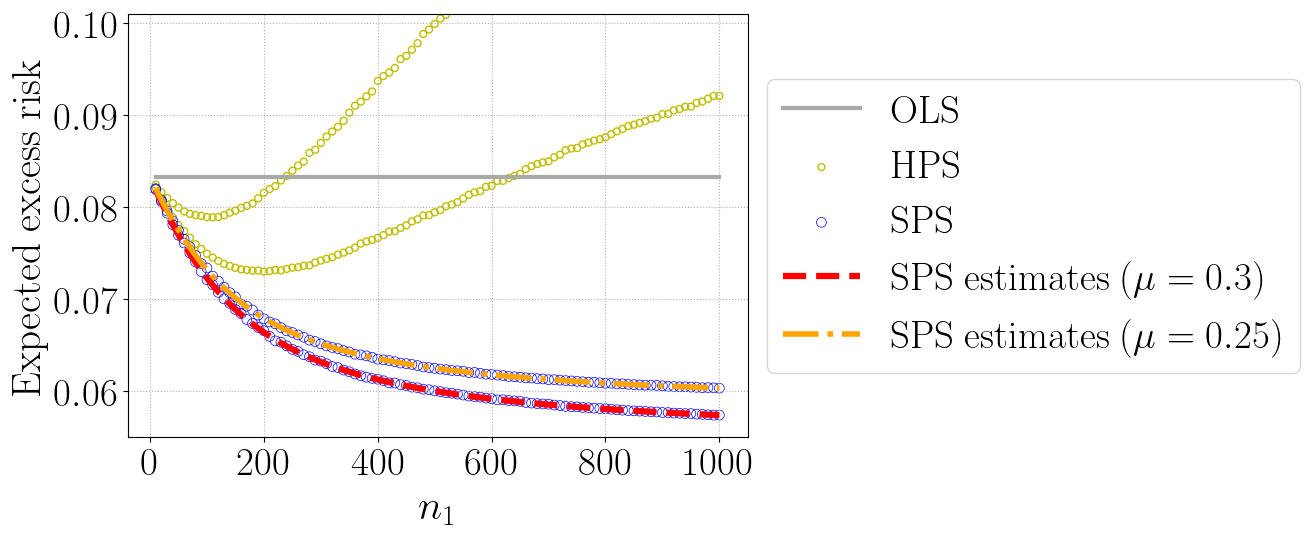

In [ ]:
plt.figure(figsize=(8,5.5))

plt.plot(n1_list, ols_list, c='darkgrey', lw=3, label=r'$\mathrm{OLS}$')

plt.scatter(n1_list, emp_list_4, facecolors='none', edgecolors='y', s=25, lw=1, label=r'$\mathrm{HPS}$')
#plt.plot(n1_list, thy_list_4, c='r', lw=1, ls='dashed', label=r'$\mathrm{HPS~estimates}$' + r'$:\mu = \mathrm{'+str(d1)+'}$')


plt.scatter(n1_list, emp_list_3, facecolors='none', edgecolors='y', s=25, lw=1,)
#plt.plot(n1_list, thy_list_3, c='c', lw=7, ls=(0, (3, 3, 1, 3)), label=r'$\mathrm{HPS~estimates}$' + r'$:\mu = \mathrm{'+str(d2)+'}$')

plt.scatter(n1_list, reg_list_4, facecolors='none', edgecolors='blue', s=50, lw=0.5, label=r'$\mathrm{SPS}$')

plt.scatter(n1_list, reg_list_3, facecolors='none', edgecolors='blue', s=50, lw=0.5) # , label=r'$\mathrm{Empirical~risk~of~SPS}$' + r'$:\mu = \mathrm{'+str(d2)+'}$'

plt.plot(n1_list, sps_est_list_4, c='r', lw=4.5, ls='dashed', label=r'$\mathrm{SPS~estimates~(\mu=0.3)}$')

plt.plot(n1_list, sps_est_list_3, c='orange', lw=4, ls='dashdot', label=r'$\mathrm{SPS~estimates~(\mu=0.25)}$')


plt.xlabel(r'$n_1$', fontsize=30)
plt.ylabel(r'$\mathrm{Expected~Excess~Risk}$', fontsize=30)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

#plt.yticks(np.arange(0.06, 0.101, 0.01), fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#plt.xlim([500, 4000])
plt.ylim([0.055, 0.101])

plt.grid(ls = ':', lw=0.8)
lgd = plt.legend(fontsize=28, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
plt.savefig('sps.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [9]:
sps_est_list_3

[0.08203358429701135,
 0.0808010354413342,
 0.07963530086055284,
 0.07853543922230988,
 0.0775,
 0.0765270870897459,
 0.07561443354591775,
 0.07475948116400544,
 0.07395945945945945,
 0.07321145987011375,
 0.07251250239564525,
 0.07185959313369639,
 0.07124977215999406,
 0.07068015190980263,
 0.07014794668586073,
 0.0696504941967395,
 0.06918527016939376,
 0.06874989712046943,
 0.06834214834278074,
 0.06795994808912645,
 0.0676013688330997,
 0.06726462636978243,
 0.06694807339899328,
 0.06665019211790235,
 0.06636958624351928,
 0.06610497279173168,
 0.06585517385939277,
 0.06561910858932785,
 0.06539578544412392,
 0.06518429487179488,
 0.06498380241329164,
 0.06479354227675797,
 0.06461281138492599,
 0.0644409638887788,
 0.0642774061314395,
 0.06412159204023149,
 0.0639730189212224,
 0.06383122362869198,
 0.06369577908137253,
 0.06356629109761887,
 0.06344239552258737,
 0.06332375562182663,
 0.0632100597172413,
 0.06310101904307366,
 0.06299636580126776,
 0.06289585139728203,
 0.062799

In [10]:
X2

NameError: name 'X2' is not defined

In [ ]:
for i, n1 in enumerate(n1_list):
    print(emp_list_4[i], reg_list_4[i])
    

0.08209413010571433 8.023745209442597
0.0809116820286417 7.426088481282568
0.07996567702702184 7.8387700572922565
0.07896122833053855 8.238027293363405
0.0781040881544226 14.766441364778965
0.07730421744212777 16.091127633340093
0.07665464738793461 16.872344261553714
0.07603792158305411 17.958631192145315
0.07542922368232478 18.757934351832635
0.07497382301489944 19.67944196302819
0.07462159484144291 20.769906834089877
0.07421693605297344 21.370650194490633
0.07393759288321139 22.795018023547
0.07373226704280858 22.936639629208553
0.07338648391999382 26.055062878367984
0.0733863745620778 26.955881139549756
0.07316713459876673 26.32211957120386
0.07310948347700981 28.424014851219717
0.07306421542729155 29.340974004009063
0.07302128533922085 30.536867517169348
0.07300626206456574 29.757565466386108
0.07313941001750639 31.620700015752323
0.07322449530202534 32.1782673174447
0.07319888715770666 32.79352572680453
0.07329536746728343 33.79642149164596
0.07351698210950726 34.585994197327395
0

## Fig 3c: when d is large, transfer is always negative

## Fig 1: motivating example

In [ ]:
X2 = np.random.randn(n2, p)

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
U, D, Vt = np.linalg.svd(X2)

In [ ]:
Vt.shape

In [ ]:
U[:, :100].shape

In [ ]:
print(reg_list_4)

In [ ]:
print(sps_est_list_4)